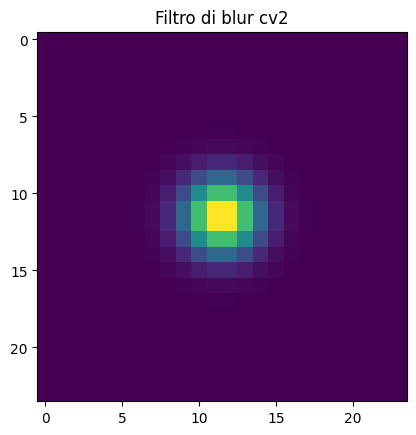

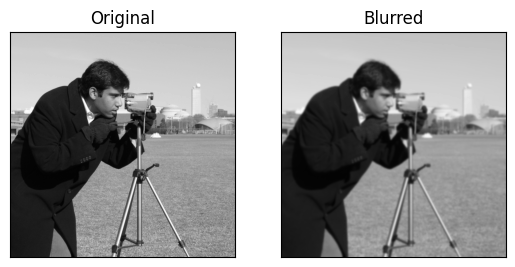

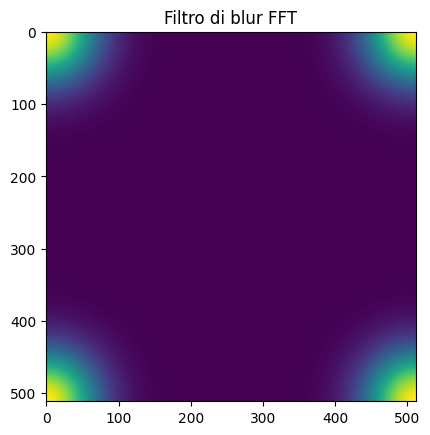

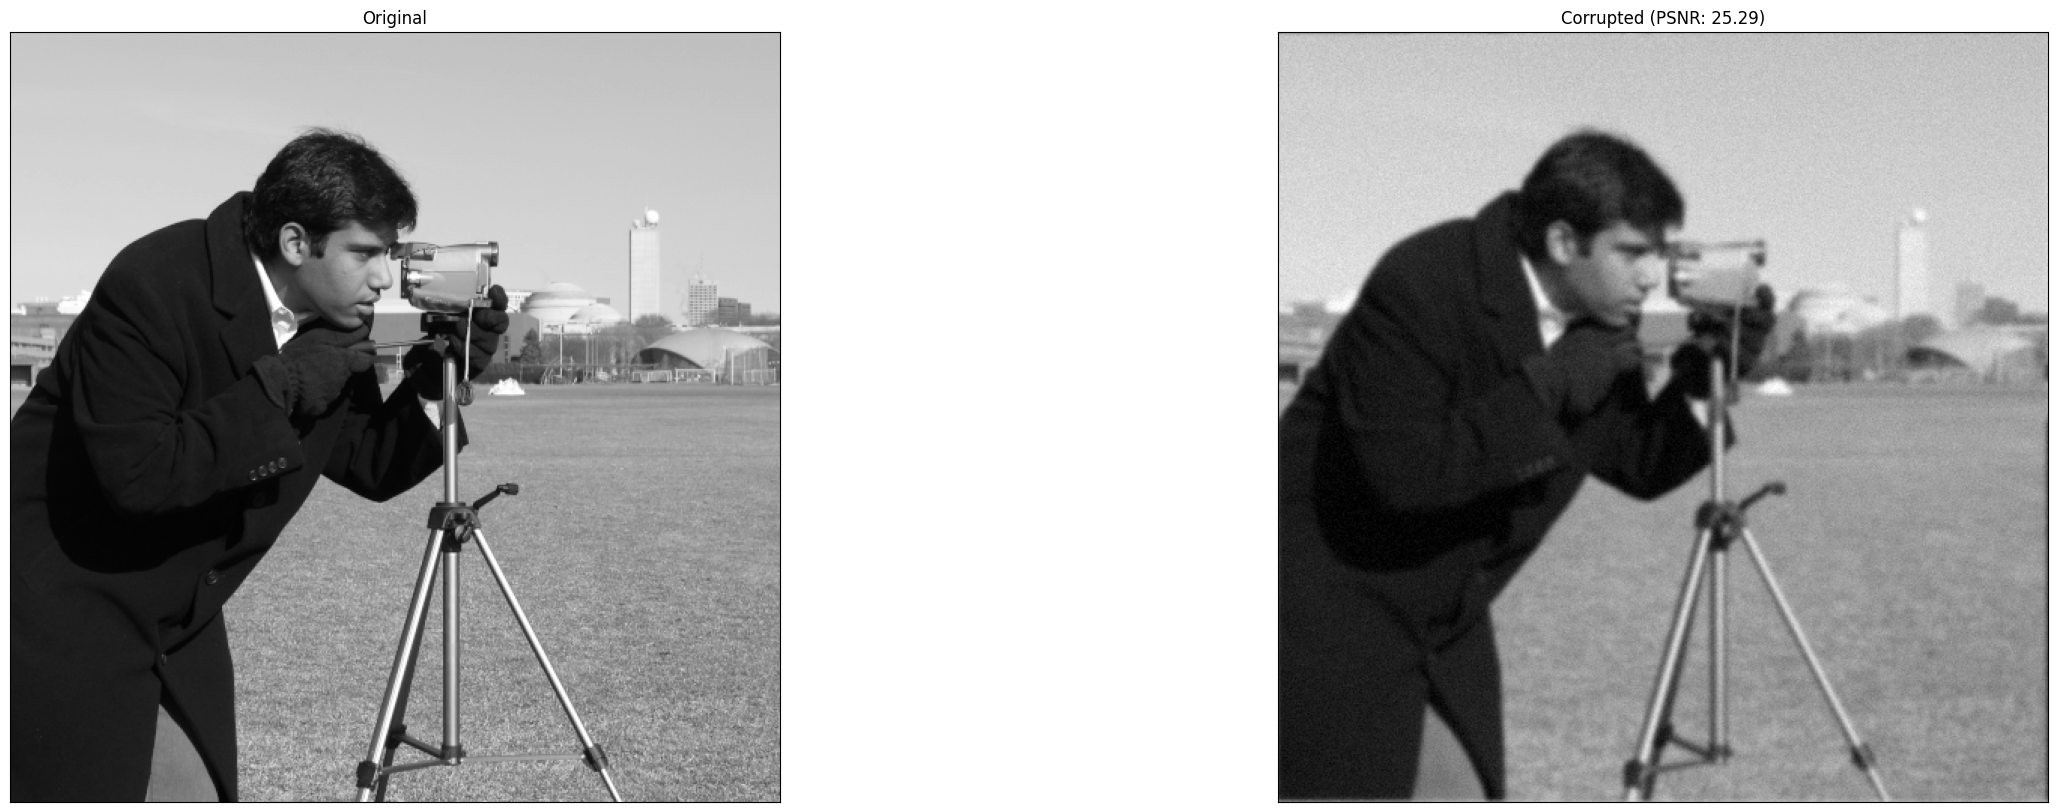

PSNR = 25.286296164887453
MSE = 0.0029605362526167783


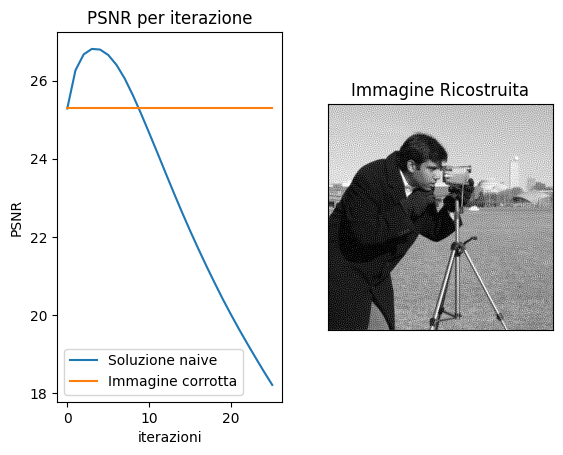

λ = 0.01


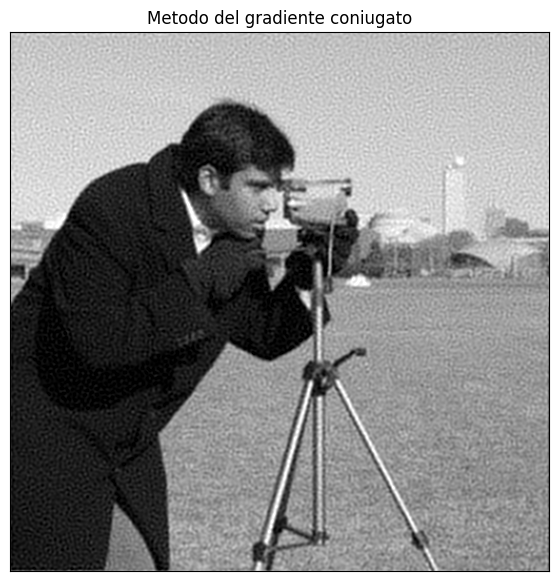

PSNR = 26.264542422473355
MSE = 0.0023634464013941696


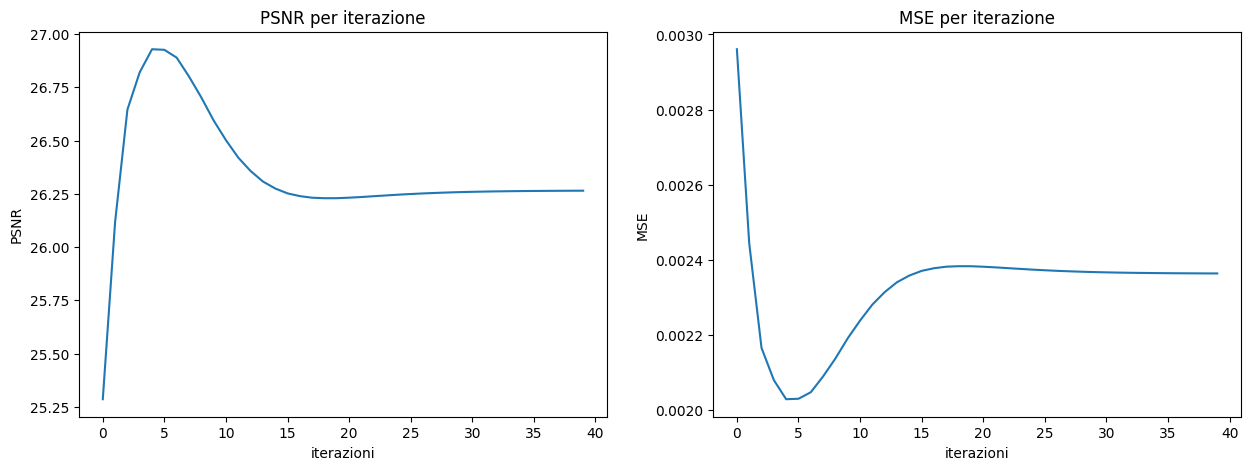

λ = 0.03


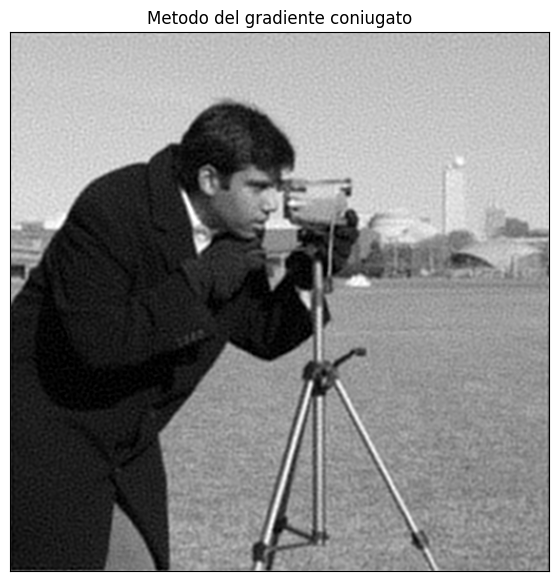

PSNR = 26.857112385209348
MSE = 0.0020620004773169464


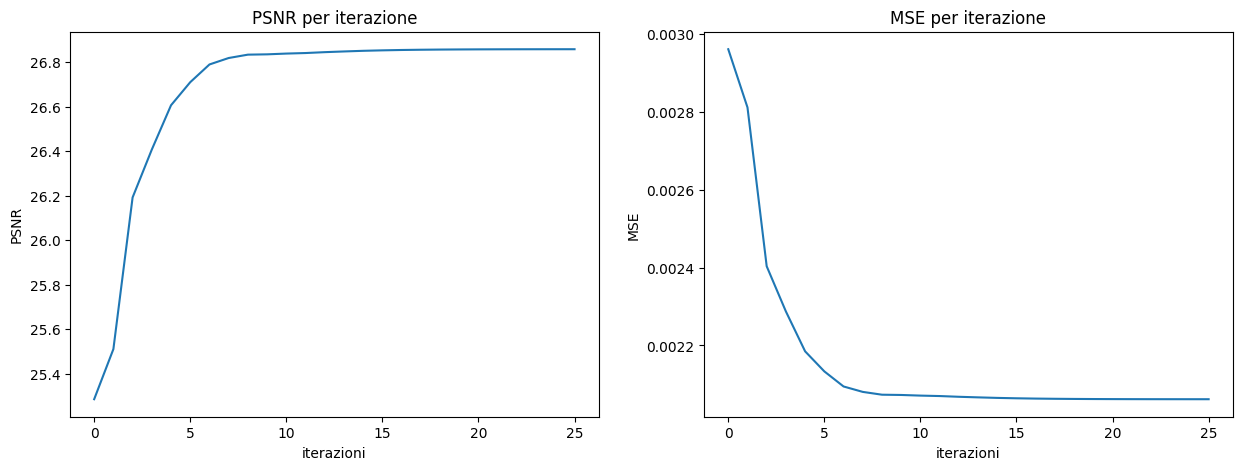

λ = 0.04


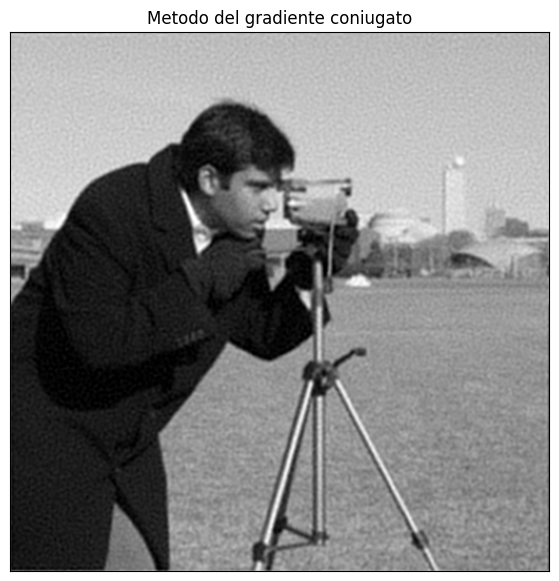

PSNR = 26.469176289376726
MSE = 0.0022546668060927375


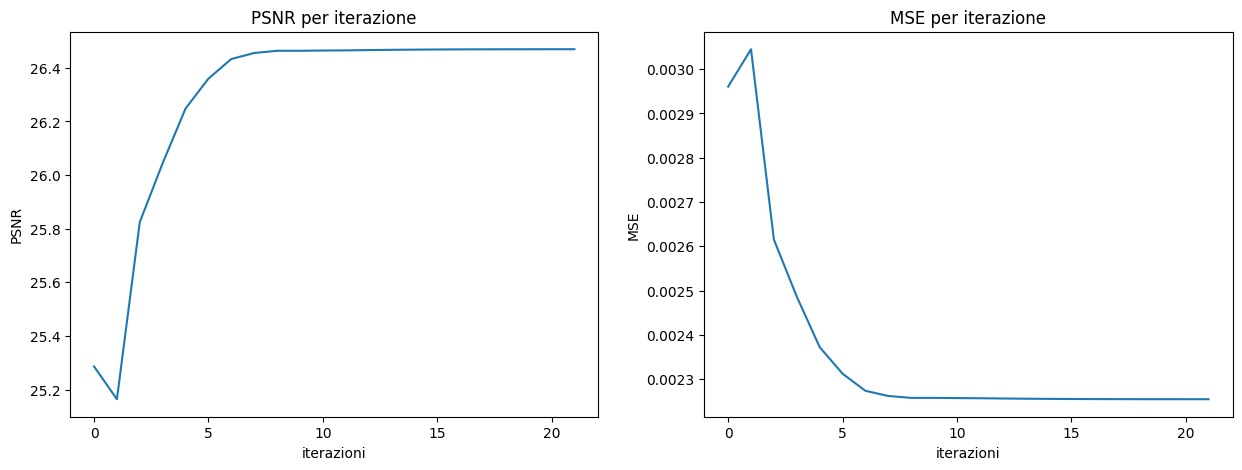

λ = 0.06


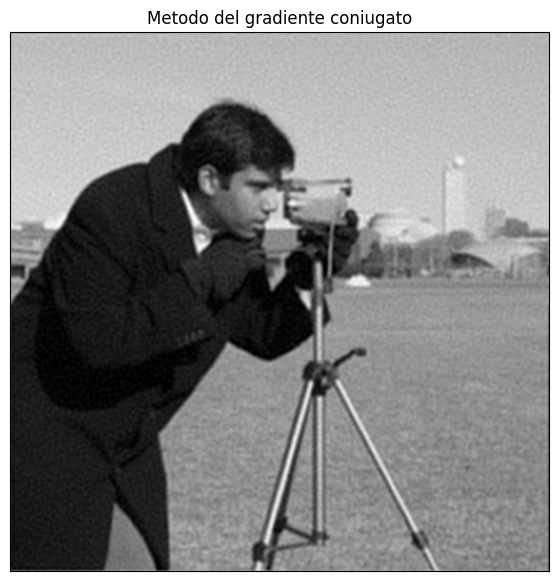

PSNR = 25.42385553716375
MSE = 0.002868233119406825


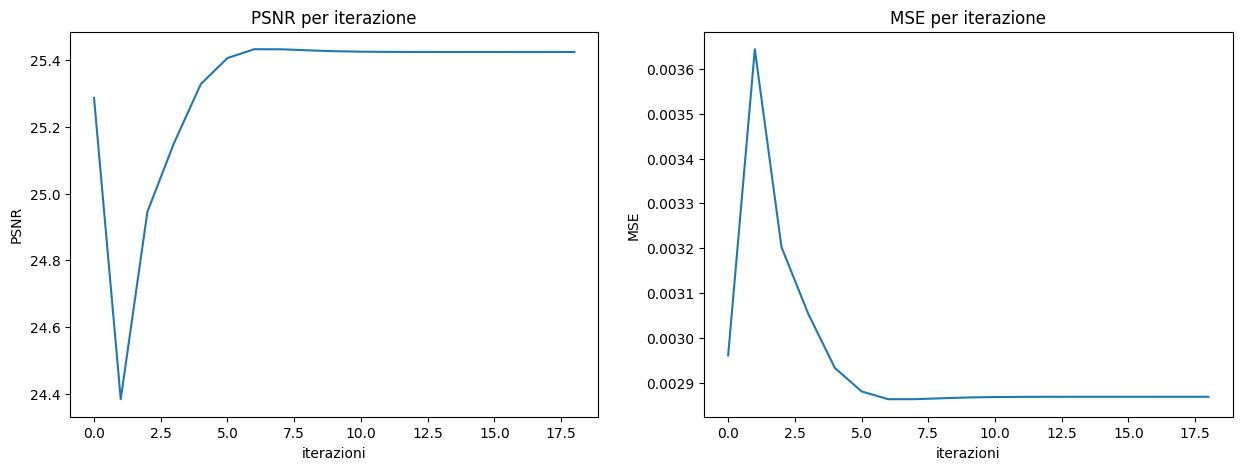

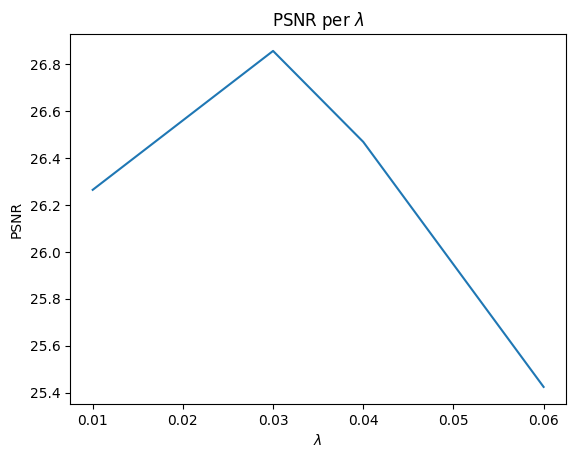

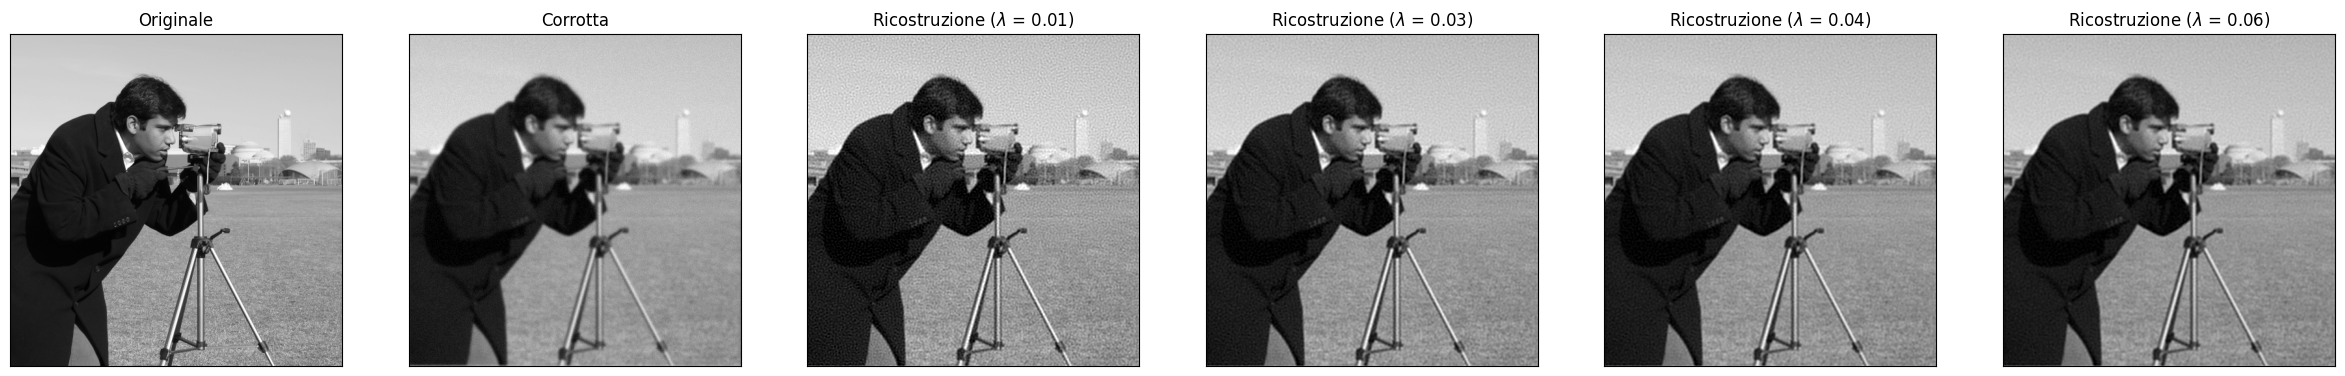

'\n# scegliere lambda con il metodo della discrepanza\nfrom scipy.optimize import minimize_scalar\n\ndef discrepanza(lambdaValue, A, b, xTrue):\n  minCG = minimizeCG(f, x0, (lambdaValue), method=\'CG\', jac=gradf, options={\'maxiter\':maxit})\n  xLambda = minCG.x.reshape(x.shape)\n  return np.linalg.norm(A @ xLambda - b) - np.linalg.norm(xLambda - xTrue)\n\ndef findOptimalLambda(A, b, xTrue):\n  return minimize_scalar(discrepanza, args=(A, b, xTrue), method=\'bounded\', bounds=(0, 1)).x\n\noptimal_lambda = findOptimalLambda(K, y, x)\nprint(f"Parametro di regolarizzazione ottimale: {optimal_lambda}")\n\nminCG = minimizeCG(f, x0, (optimal_lambda), method=\'CG\', jac=gradf, options={\'maxiter\':maxit})\nxMinCG = minCG.x.reshape(x.shape)\n\nplt.imshow(xMinCG, cmap=\'gray\', vmin=0, vmax=1)\nplt.xticks([]), plt.yticks([])\nplt.show()\n\nPSNR = metrics.peak_signal_noise_ratio(x, xMinCG)\nprint("PSNR =", PSNR)\nMSE = metrics.mean_squared_error(x, xMinCG)\nprint("MSE =", MSE)\n'

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from skimage import data, metrics
from numpy import fft

#Domanda 13


def gaussian_kernel(kernlen, sigma):
  x = np.linspace(- (kernlen // 2), kernlen // 2, kernlen)    
  kern1d = np.exp(- 0.5 * (x**2 / sigma))
  kern2d = np.outer(kern1d, kern1d)
  return kern2d / kern2d.sum()

def psf_fft(K, d, shape):
  K_p = np.zeros(shape)
  K_p[:d, :d] = K
  p = d // 2
  K_pr = np.roll(np.roll(K_p, -p, 0), -p, 1) # fa lo shift degli elementi del vettore di p posizioni
  K_otf = fft.fft2(K_pr)
  return K_otf

# Moltiplicazione per A
def A(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(K * x))

# Moltiplicazione per A trasposta
def AT(x, K):
  x = fft.fft2(x)
  return np.real(fft.ifft2(np.conj(K) * x))


# caricare immagine e normalizzarla
x = data.camera().astype(np.float64) / 255.0
m, n = x.shape

# applicare blur gaussiano
k = gaussian_kernel(24, 3)
plt.imshow(k)
plt.title("Filtro di blur cv2")
plt.show()

xBlur = cv.filter2D(x, -1, k)
plt.subplot(121).imshow(x, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(xBlur, cmap='gray', vmin=0, vmax=1)
plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

K = psf_fft(k, 24, x.shape)
plt.imshow(np.abs(K))
plt.title("Filtro di blur FFT")
plt.show()

xBlur = A(x, K)

# aggiungere rumore gaussiano
sigma = 0.02
np.random.seed(42)
noise = np.random.normal(size=x.shape) * sigma
y = xBlur + noise

# calcolare PSNR e MSE
PSNR = metrics.peak_signal_noise_ratio(x, y)
MSE = metrics.mean_squared_error(x, y)

plt.figure(figsize=(30, 10))
plt.subplot(121).imshow(x, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title(f'Corrupted (PSNR: {PSNR:.2f})')
plt.xticks([]), plt.yticks([])
plt.show()

print("PSNR =", PSNR)
print("MSE =", MSE)

from scipy.optimize import minimize as minimizeCG

def f(t):
    t = t.reshape(x.shape)
    At = A(t, K)
    return 0.5 * np.sum(np.square(At - y))

def gradf(t):
  t = t.reshape(x.shape)
  ATAt = AT(A(t, K), K)
  ATy = AT(y, K)
  d = ATAt - ATy
  return d.reshape(m * n)

# calcolare la soluzione naive
x0 = y.reshape(m * n)
maxit = 25
min = minimizeCG(f, x0, method='CG', jac=gradf, options={'maxiter':maxit, 'return_all':True})
xMin = min.x.reshape(x.shape)

# analizzare PSNR e MSE
PSNR = np.zeros(maxit + 1)
MSE = np.zeros(maxit + 1)
for k, x_k in enumerate(min.allvecs):
  PSNR[k] = metrics.peak_signal_noise_ratio(x, x_k.reshape(x.shape))
  MSE[k] = metrics.mean_squared_error(x, x_k.reshape(x.shape))
startingPSNR = np.full(PSNR.shape[0], metrics.peak_signal_noise_ratio(x, y))

ax2 = plt.subplot(1, 2, 1)
ax2.plot(PSNR, label="Soluzione naive")
ax2.plot(startingPSNR, label="Immagine corrotta")
plt.legend()
plt.title('PSNR per iterazione')
plt.ylabel("PSNR")
plt.xlabel('iterazioni')
plt.subplot(1, 2, 2).imshow(xMin, cmap='gray', vmin=0, vmax=1)
plt.title('Immagine Ricostruita')
plt.xticks([]), plt.yticks([])
plt.show()


def f(t, L):
  nsq = np.sum(np.square(t))
  t = t.reshape(x.shape)
  At = A(t, K)
  return 0.5 * np.sum(np.square(At - y)) + 0.5 * L * nsq

def gradf(t, L):
  Lt = L * t
  t = t.reshape(x.shape)
  ATAt = AT(A(t, K), K) 
  ATy = AT(y, K)
  d = ATAt - ATy
  return d.reshape(m * n) + Lt


# ricostruzione con lambda diversi
lambdas = [0.01, 0.03, 0.04, 0.06]
PSNRs = []
images = []
x0 = y.reshape(m * n)
maxit = 50
toll = 1.e-5

for i, L in enumerate(lambdas):
  print(f"\u03BB = {L:.2f}")
  # calcolare la soluzione del problema regolarizzato
  ### minGrad = minimize(f, gradf, L, x0, maxit, toll)
  ### xMinGrad = minGrad.reshape(x.shape)
  minCG = minimizeCG(f, x0, (L), method='CG', jac=gradf, options={'maxiter':maxit, 'return_all':True})
  xMinCG = minCG.x.reshape(x.shape)
  images.append(xMinCG)

  
  plt.figure(figsize=(12, 7)) 
  plt.xticks([]), plt.yticks([])
  plt.imshow(xMinCG, cmap='gray', vmin=0, vmax=1)
  plt.title("Metodo del gradiente coniugato")
  plt.xticks([]), plt.yticks([])
  plt.show()
  

  PSNR = metrics.peak_signal_noise_ratio(x, xMinCG)
  PSNRs.append(PSNR)
  print("PSNR =", PSNR)
  MSE = metrics.mean_squared_error(x, xMinCG)
  print("MSE =", MSE)

  # analizzare PSNR e MSE
  PSNRL = []
  MSEL = []
  for k, x_k in enumerate(minCG.allvecs):
    PSNRL.append(metrics.peak_signal_noise_ratio(x, x_k.reshape(x.shape)))
    MSEL.append(metrics.mean_squared_error(x, x_k.reshape(x.shape)))
  
  plt.figure(figsize=(15, 5))
  ax2 = plt.subplot(1, 2, 1)
  ax2.plot(PSNRL)
  plt.title('PSNR per iterazione')
  plt.ylabel("PSNR")
  plt.xlabel('iterazioni')
  plt.subplot(1, 2, 2).plot(MSEL)
  plt.title('MSE per iterazione')
  plt.ylabel("MSE")
  plt.xlabel('iterazioni')
  plt.show()
  
plt.plot(lambdas, PSNRs)
plt.title('PSNR per $\lambda$')
plt.ylabel("PSNR")
plt.xlabel('$\lambda$')
plt.show()

plt.figure(figsize=(30, 10))
plt.subplot(1, len(lambdas) + 2, 1).imshow(x, cmap='gray', vmin=0, vmax=1)
plt.title("Originale")
plt.xticks([]), plt.yticks([])
plt.subplot(1, len(lambdas) + 2, 2).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title("Corrotta")
plt.xticks([]), plt.yticks([])

for i, L in enumerate(lambdas):
  plt.subplot(1, len(lambdas) + 2, i + 3).imshow(images[i], cmap='gray', vmin=0, vmax=1)
  plt.title(f"Ricostruzione ($\lambda$ = {L:.2f})")
  plt.xticks([]), plt.yticks([])
plt.show()

'''
# scegliere lambda con il metodo della discrepanza
from scipy.optimize import minimize_scalar

def discrepanza(lambdaValue, A, b, xTrue):
  minCG = minimizeCG(f, x0, (lambdaValue), method='CG', jac=gradf, options={'maxiter':maxit})
  xLambda = minCG.x.reshape(x.shape)
  return np.linalg.norm(A @ xLambda - b) - np.linalg.norm(xLambda - xTrue)

def findOptimalLambda(A, b, xTrue):
  return minimize_scalar(discrepanza, args=(A, b, xTrue), method='bounded', bounds=(0, 1)).x

optimal_lambda = findOptimalLambda(K, y, x)
print(f"Parametro di regolarizzazione ottimale: {optimal_lambda}")

minCG = minimizeCG(f, x0, (optimal_lambda), method='CG', jac=gradf, options={'maxiter':maxit})
xMinCG = minCG.x.reshape(x.shape)

plt.imshow(xMinCG, cmap='gray', vmin=0, vmax=1)
plt.xticks([]), plt.yticks([])
plt.show()

PSNR = metrics.peak_signal_noise_ratio(x, xMinCG)
print("PSNR =", PSNR)
MSE = metrics.mean_squared_error(x, xMinCG)
print("MSE =", MSE)
'''

'''
# metodo del gradiente con backtracking e regolarizzazione
def minimize(f, gradf, L, x0, maxit, toll):
  xLast = x0
  k = 0
  while (np.linalg.norm(gradf(xLast, L)) > toll and k < maxit):
    k = k + 1
    grad = gradf(xLast, L)
    step = backtracking(xLast, f, grad, L)
    if (step == -1):
      print("Non convergente")
      return k
    xLast = xLast - step*grad
  return xLast

def backtracking(x, f, grad, L):
  alpha = 1
  rho = 0.5
  c1 = 0.25 
  p = -grad
  j = 0
  jmax = 10
  while ((f(x + alpha*p, L) > f(x, L) + c1*alpha*np.dot(grad, p)) and j < jmax):
    alpha = rho*alpha
    j = j + 1
  if (j > jmax):
    return -1
  else:
    return alpha
'''


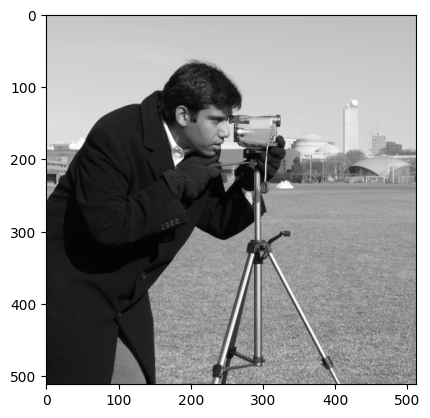

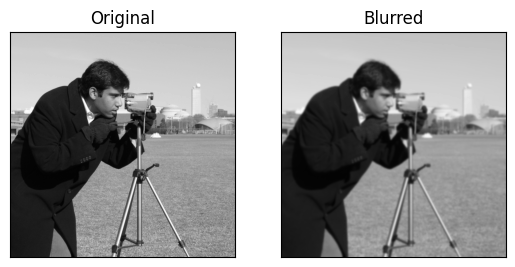

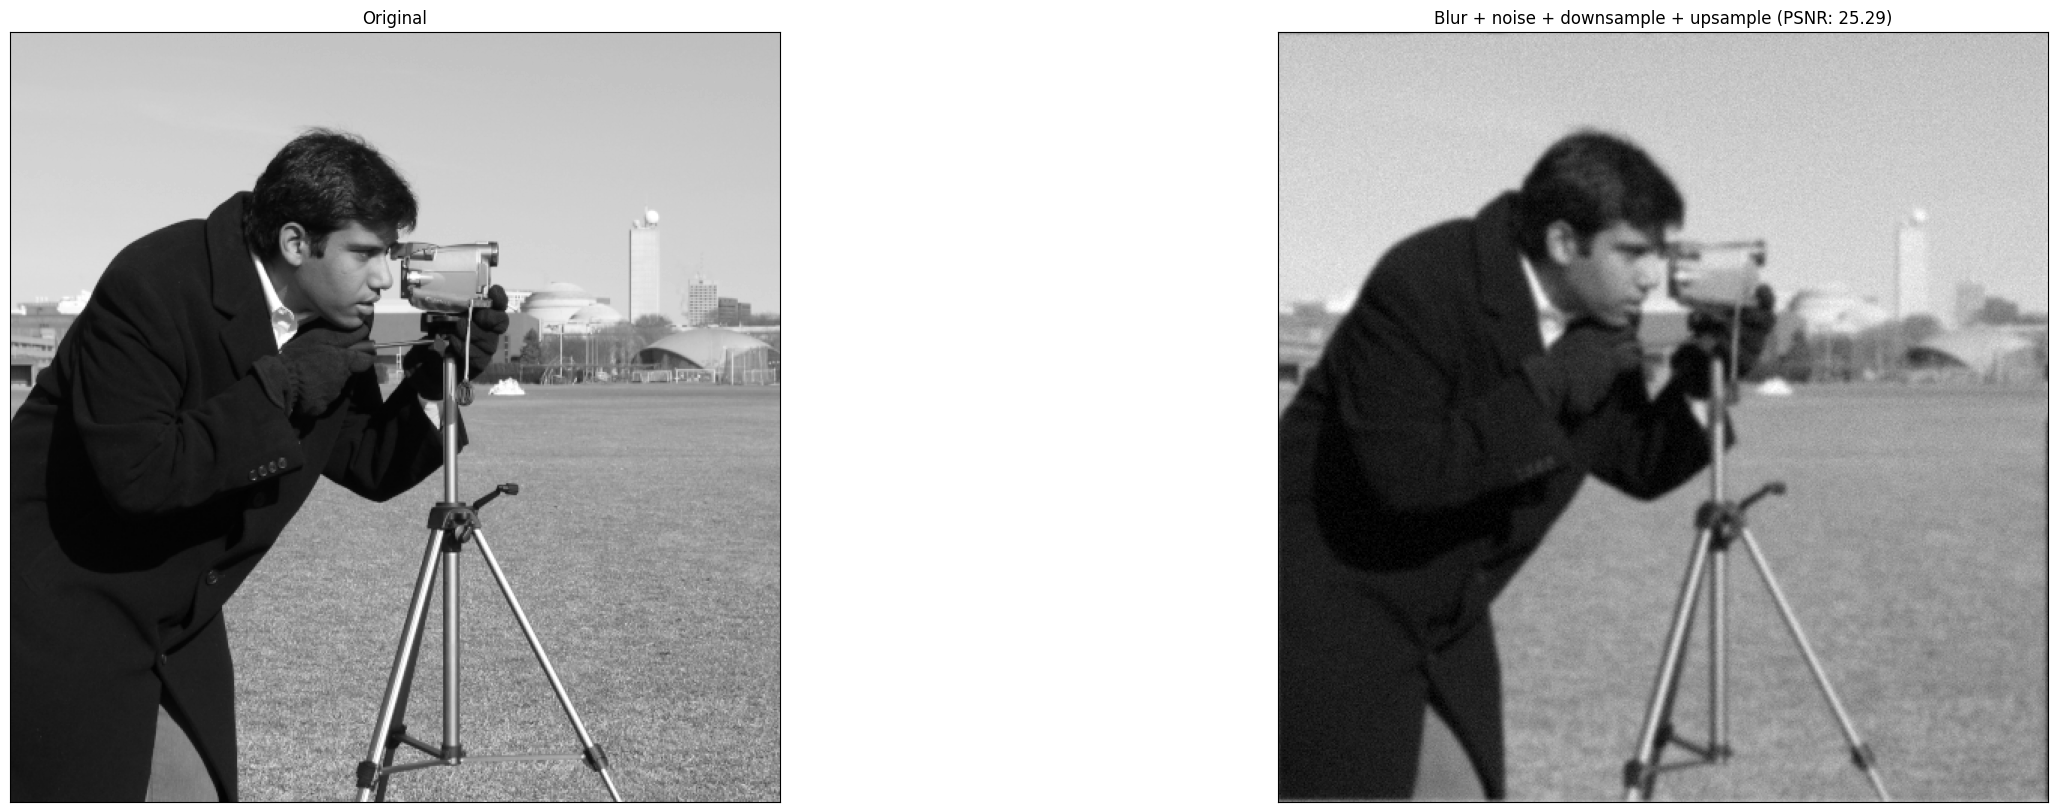

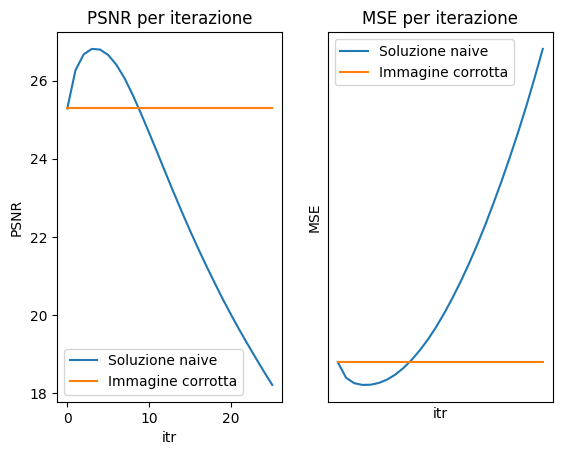

PSNR: 26.26 (λ = 0.01)
PSNR: 26.86 (λ = 0.03)
PSNR: 26.47 (λ = 0.04)
PSNR: 6.25 (λ = 5.00)


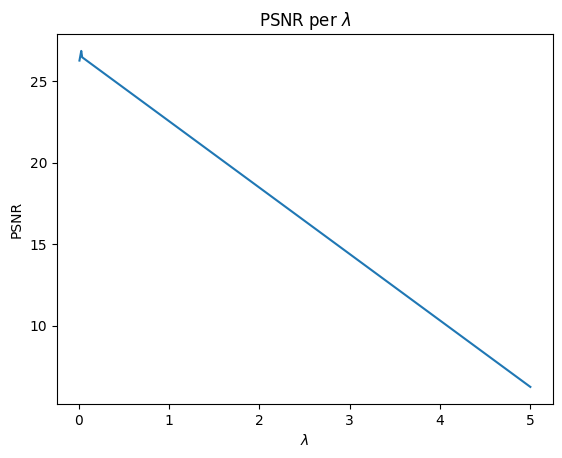

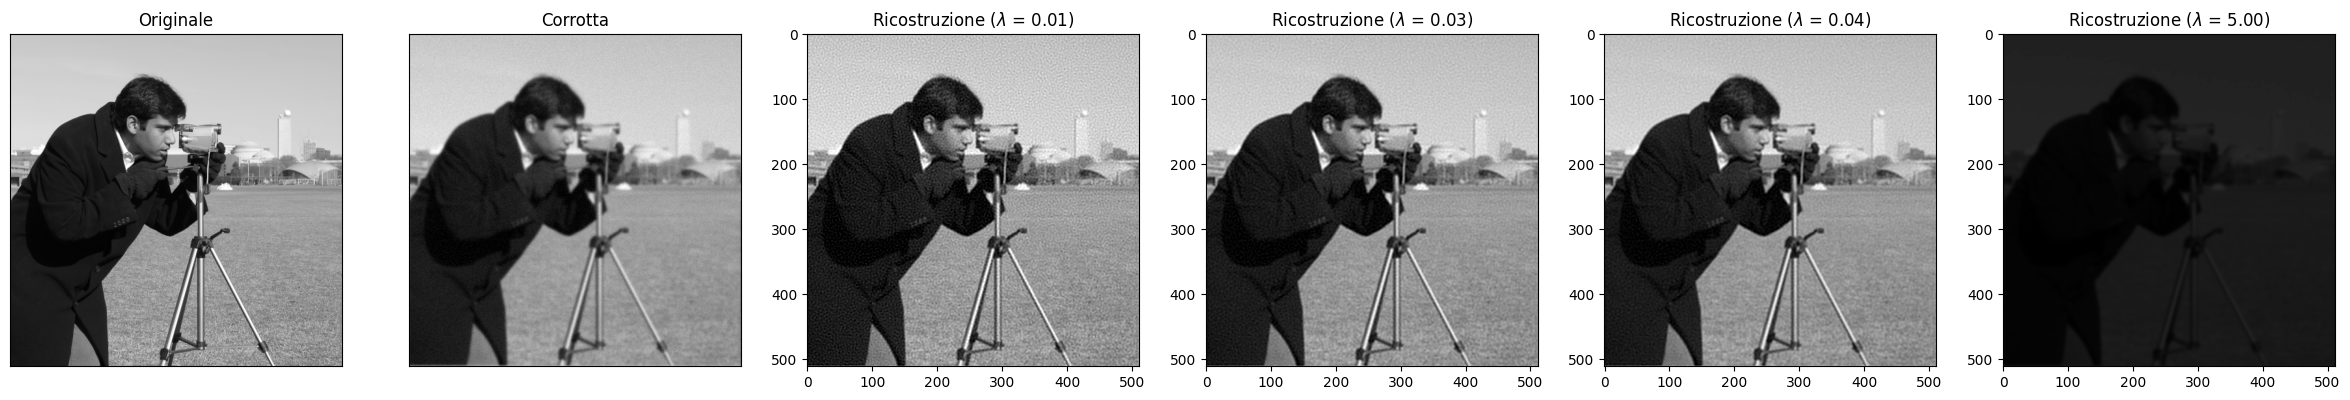

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, metrics
from utils import psf_fft, A, AT, gaussian_kernel
from scipy.optimize import minimize

#Domanda 14

X = data.camera().astype(np.float64)
plt.imshow(X, cmap='gray')
plt.show()
X = X / 255
m, n = X.shape

# Filtro
k = gaussian_kernel(24, 3)

# Blur con OpenCV
X_blurred = cv.filter2D(X, -1, k)
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(X_blurred, cmap='gray', vmin=0, vmax=1)
plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.show()

# Blur con FFT
K = psf_fft(k, 24, X.shape)
X_blurred = A(X, K)


#Downsampling
scale_percent = 50
width = int(X_blurred.shape[1] * scale_percent / 100)
height = int(X_blurred.shape[0] * scale_percent / 100)
dim = (width, height)
resized = cv.resize(X_blurred, dim)


#Generazione rumore
sigma = 0.02
np.random.seed(42)
noise = np.random.normal(size=X.shape) * sigma

# Aggiungi blur e rumore
y = X_blurred + noise
PSNR = metrics.peak_signal_noise_ratio(X, y)
mse = metrics.mean_squared_error(X, y)

#Upsampling
scale_percent = 200
width = int(resized.shape[1] * scale_percent / 100)
height = int(resized.shape[0] * scale_percent / 100)
dim = (width, height)
X_blurred = cv.resize(resized, dim)

ATy = AT(y, K)
plt.figure(figsize=(30, 10))
plt.subplot(121).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title(f'Blur + noise + downsample + upsample (PSNR: {PSNR:.2f})')
plt.xticks([]), plt.yticks([])
plt.show()

#Naive
def f(x):
    x = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y))

def df(x):
    x = x.reshape((m, n))
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n)

x0 = y.reshape(m*n)
max_iter = 25
res = minimize(f, x0, method='CG', jac=df, options={'maxiter':max_iter,'return_all':True})

PSNR = np.zeros(max_iter + 1)
mse = np.zeros(max_iter + 1)

for k, x_k in enumerate(res.allvecs):
    PSNR[k] = metrics.peak_signal_noise_ratio(X, x_k.reshape(X.shape))
    mse[k] = metrics.mean_squared_error(X, x_k.reshape(X.shape))
    
X_res = res.x.reshape((m, n))

starting_PSNR = np.full(PSNR.shape[0], metrics.peak_signal_noise_ratio(X, y))
starting_mse = np.full(mse.shape[0], metrics.mean_squared_error(X, y))

ax2 = plt.subplot(1, 2, 1)
ax2.plot(PSNR, label="Soluzione naive")
ax2.plot(starting_PSNR, label="Immagine corrotta")
plt.legend()
plt.title('PSNR per iterazione')
plt.ylabel("PSNR")
plt.xlabel('itr')

ax3 = plt.subplot(1, 2, 2)
ax3.plot(mse, label="Soluzione naive")
ax3.plot(starting_mse, label="Immagine corrotta")
plt.legend()
plt.title('MSE per iterazione')
plt.ylabel("MSE")
plt.xlabel('itr')

plt.xticks([]), plt.yticks([])
plt.show()

#Tikhonov
def f(x, L):
    nsq = np.sum(np.square(x))
    x = x.reshape((m, n))
    Ax = A(x, K)
    return 0.5 * np.sum(np.square(Ax - y)) + 0.5 * L * nsq

def df(x, L):
    Lx = L * x
    x = x.reshape(m, n)
    ATAx = AT(A(x,K),K)
    d = ATAx - ATy
    return d.reshape(m * n) + Lx

x0 = y.reshape(m*n)
lambdas = [0.01,0.03,0.04, 5.0]
PSNRs = []
images = []

for i, L in enumerate(lambdas):
    max_iter = 50
    res = minimize(f, x0, (L), method='CG', jac=df, options={'maxiter': max_iter})
    X_curr = res.x.reshape(X.shape)
    images.append(X_curr)
    PSNR = metrics.peak_signal_noise_ratio(X, X_curr)
    PSNRs.append(PSNR)
    print(f'PSNR: {PSNR:.2f} (\u03BB = {L:.2f})')

plt.plot(lambdas,PSNRs)
plt.title('PSNR per $\lambda$')
plt.ylabel("PSNR")
plt.xlabel('$\lambda$')
plt.show()

plt.figure(figsize=(30, 10))
plt.subplot(1, len(lambdas) + 2, 1).imshow(X, cmap='gray', vmin=0, vmax=1)
plt.title("Originale")
plt.xticks([]), plt.yticks([])
plt.subplot(1, len(lambdas) + 2, 2).imshow(y, cmap='gray', vmin=0, vmax=1)
plt.title("Corrotta")
plt.xticks([]), plt.yticks([])
for i, L in enumerate(lambdas):
    plt.subplot(1, len(lambdas) + 2, i + 3).imshow(images[i], cmap='gray', vmin=0, vmax=1)
    plt.title(f"Ricostruzione ($\lambda$ = {L:.2f})")
plt.show()


